In [22]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/clouds-ml/src

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/clouds-ml/src


In [ ]:
# # one-time per session
# !mkdir -p /content/images
# !rsync -a --info=progress2 "/content/drive/MyDrive/clouds-ml/data/images/" "/content/images/"

    229,702,660 100%   27.15MB/s    0:00:08 (xfr#1000, to-chk=0/1001)


In [28]:
import os, math, random, time
import pandas as pd
import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.amp import GradScaler, autocast

from tqdm.auto import tqdm
from config import BASE_DIR, DATA_PROCESSED, MODELS_DIR

In [29]:
CSV_PATH  = os.path.join(DATA_PROCESSED, "main.csv")
SAVE_PATH = os.path.join(MODELS_DIR, "resnet18_mvp.pth")
os.makedirs(MODELS_DIR, exist_ok=True)

In [30]:
df = pd.read_csv(CSV_PATH)
def to_full(p: str | None):
    if isinstance(p, str):
        return os.path.join(BASE_DIR, p)
    return None

df["full_path"] = df["local_path"].apply(to_full)
df["full_path"] = df["full_path"].str.replace(
    "/content/drive/MyDrive/clouds-ml/data/images", "/content/images", regex=False
)
df = df[df["full_path"].apply(lambda p: isinstance(p, str) and os.path.isfile(p))].reset_index(drop=True)


In [31]:
CLOUD_COLS = [
    "altocumulus","altostratus","cirrocumulus","cirrostratus",
    "cirrus","cumulonimbus","cumulus","nimbostratus","stratocumulus","stratus"
]
num_classes = len(CLOUD_COLS)

class CloudDataset(Dataset):
    def __init__(self, df, transform=None):
        self.paths  = df["full_path"].tolist()
        self.labels = df[CLOUD_COLS].to_numpy(dtype=np.float32)
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, torch.from_numpy(self.labels[i])

img_size = 224
train_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.1, hue=0.03),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

val_frac = 0.2
val_size = int(len(df) * val_frac)
train_size = len(df) - val_size
g = torch.Generator().manual_seed(42)
indices = torch.randperm(len(df), generator=g).tolist()
train_idx, val_idx = indices[:train_size], indices[train_size:]

train_df = df.iloc[train_idx].reset_index(drop=True)
val_df   = df.iloc[val_idx].reset_index(drop=True)

train_ds = CloudDataset(train_df, transform=train_tfms)
val_ds   = CloudDataset(val_df,   transform=val_tfms)

batch_size = 64
use_cuda = torch.cuda.is_available()
train_dl = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=use_cuda, persistent_workers=True, prefetch_factor=2
)
val_dl = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=use_cuda, persistent_workers=True, prefetch_factor=2
)

print(f"Train: {len(train_ds)}  |  Val: {len(val_ds)}  |  Batch: {batch_size}")


Train: 800  |  Val: 200  |  Batch: 64


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [32]:
device = torch.device("cuda" if use_cuda else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, num_classes)
model = model.to(device)

criterion  = nn.BCEWithLogitsLoss()
optimizer  = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler  = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

torch.backends.cudnn.benchmark = True
scaler = GradScaler(enabled=use_cuda, device="cuda")

@torch.no_grad()
def evaluate(model, dl, thresh=0.5):
    model.eval()
    total_loss, n_samples = 0.0, 0
    correct_per_label = torch.zeros(num_classes, dtype=torch.long)
    total_per_label   = torch.zeros(num_classes, dtype=torch.long)
    exact_correct = 0

    for imgs, labels in dl:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        total_loss += loss.item() * imgs.size(0)
        n_samples  += imgs.size(0)

        preds = (logits.sigmoid() >= thresh).long()
        correct_per_label += (preds == labels.long()).sum(dim=0).cpu()
        total_per_label   += torch.tensor([imgs.size(0)] * num_classes)
        exact_correct     += (preds.eq(labels.long()).all(dim=1)).sum().item()

    avg_loss = total_loss / max(1, n_samples)
    per_label_acc = (correct_per_label.float() / total_per_label.clamp(min=1).float()).tolist()
    exact_match = exact_correct / max(1, n_samples)
    return avg_loss, per_label_acc, exact_match

epochs = 5
best_val = float('inf')

for epoch in range(1, epochs+1):
    model.train()
    pbar = tqdm(train_dl, desc=f"Epoch {epoch}/{epochs}", leave=False)
    running_loss, n_seen = 0.0, 0

    for imgs, labels in pbar:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast("cuda", enabled=use_cuda, dtype=torch.float16):
            logits = model(imgs)
            loss = criterion(logits, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * imgs.size(0)
        n_seen += imgs.size(0)
        pbar.set_postfix(train_loss=f"{running_loss / max(1, n_seen):.4f}")

    val_loss, per_label_acc, exact_match = evaluate(model, val_dl, thresh=0.5)
    scheduler.step(val_loss)

    print(f"[Epoch {epoch}] val_loss={val_loss:.4f}  exact_match={exact_match:.4f}")
    short = {lbl: f"{acc:.3f}" for lbl, acc in zip(CLOUD_COLS, per_label_acc)}
    print(" per-label acc:", short)

torch.save({
    "model": model.state_dict(),
    "labels": CLOUD_COLS,
    "epoch": epochs
}, SAVE_PATH)

print(f"Saved final model to {SAVE_PATH}")

print("Done.")

Epoch 1/5:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 1] val_loss=1.8417  exact_match=0.2200
 per-label acc: {'altocumulus': '0.775', 'altostratus': '0.810', 'cirrocumulus': '0.835', 'cirrostratus': '0.905', 'cirrus': '0.750', 'cumulonimbus': '0.965', 'cumulus': '0.565', 'nimbostratus': '0.880', 'stratocumulus': '0.830', 'stratus': '0.935'}


Epoch 2/5:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 2] val_loss=1.2091  exact_match=0.2400
 per-label acc: {'altocumulus': '0.775', 'altostratus': '0.810', 'cirrocumulus': '0.835', 'cirrostratus': '0.875', 'cirrus': '0.765', 'cumulonimbus': '0.965', 'cumulus': '0.660', 'nimbostratus': '0.880', 'stratocumulus': '0.835', 'stratus': '0.935'}


Epoch 3/5:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 3] val_loss=0.7907  exact_match=0.1700
 per-label acc: {'altocumulus': '0.770', 'altostratus': '0.610', 'cirrocumulus': '0.835', 'cirrostratus': '0.820', 'cirrus': '0.660', 'cumulonimbus': '0.965', 'cumulus': '0.645', 'nimbostratus': '0.890', 'stratocumulus': '0.890', 'stratus': '0.930'}


Epoch 4/5:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 4] val_loss=0.3771  exact_match=0.3200
 per-label acc: {'altocumulus': '0.770', 'altostratus': '0.845', 'cirrocumulus': '0.840', 'cirrostratus': '0.900', 'cirrus': '0.755', 'cumulonimbus': '0.965', 'cumulus': '0.780', 'nimbostratus': '0.905', 'stratocumulus': '0.835', 'stratus': '0.935'}


Epoch 5/5:   0%|          | 0/13 [00:00<?, ?it/s]

[Epoch 5] val_loss=0.3782  exact_match=0.2600
 per-label acc: {'altocumulus': '0.770', 'altostratus': '0.870', 'cirrocumulus': '0.835', 'cirrostratus': '0.860', 'cirrus': '0.735', 'cumulonimbus': '0.950', 'cumulus': '0.735', 'nimbostratus': '0.895', 'stratocumulus': '0.820', 'stratus': '0.930'}
💾 Saved final model to /content/drive/MyDrive/clouds-ml/models/resnet18_mvp.pth
Done.


In [33]:
import os, io, hashlib, requests
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import pandas as pd
import numpy as np

from config import DATA_PROCESSED, MODELS_DIR
CAS_CSV   = os.path.join(DATA_PROCESSED, "cas_clean.csv")
CKPT_PATH = os.path.join(MODELS_DIR, "resnet18_mvp.pth")
CACHE_DIR = Path("/content/cas_cache"); CACHE_DIR.mkdir(parents=True, exist_ok=True)

cas_df = pd.read_csv(CAS_CSV)

CLOUD_COLS = [
    "altocumulus","altostratus","cirrocumulus","cirrostratus",
    "cirrus","cumulonimbus","cumulus","nimbostratus","stratocumulus","stratus"
]
num_classes = len(CLOUD_COLS)

img_size = 224
val_tfms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

_session = requests.Session()
def url_to_pil(url: str) -> Image.Image:
    h = hashlib.sha1(url.encode("utf-8")).hexdigest()[:20]
    fp = CACHE_DIR / f"{h}.jpg"
    if fp.exists():
        return Image.open(fp).convert("RGB")
    r = _session.get(url, timeout=15)
    r.raise_for_status()
    img = Image.open(io.BytesIO(r.content)).convert("RGB")
    img.save(fp)
    return img

class UrlCloudDataset(Dataset):
    def __init__(self, df, transform=None):
        self.urls   = df["photo_url"].tolist()
        self.labels = df[CLOUD_COLS].to_numpy(dtype=np.float32)
        self.transform = transform
    def __len__(self): return len(self.urls)
    def __getitem__(self, i):
        img = url_to_pil(self.urls[i])
        if self.transform: img = self.transform(img)
        return img, torch.from_numpy(self.labels[i])

use_cuda = torch.cuda.is_available()
cas_ds = UrlCloudDataset(cas_df, transform=val_tfms)
cas_dl = DataLoader(cas_ds, batch_size=32, shuffle=False,
                    num_workers=2, pin_memory=use_cuda)

device = torch.device("cuda" if use_cuda else "cpu")

ckpt = torch.load(CKPT_PATH, map_location=device)
model = models.resnet18(weights=None)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, num_classes)
model.load_state_dict(ckpt["model"])
model = model.to(device)
model.eval()

criterion = nn.BCEWithLogitsLoss()

@torch.no_grad()
def evaluate(model, dl, thresh=0.5):
    model.eval()
    total_loss, n_samples = 0.0, 0
    correct_per_label = torch.zeros(num_classes, dtype=torch.long)
    total_per_label   = torch.zeros(num_classes, dtype=torch.long)
    exact_correct = 0

    for imgs, labels in dl:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        loss = criterion(logits, labels)
        total_loss += loss.item() * imgs.size(0)
        n_samples  += imgs.size(0)

        preds = (logits.sigmoid() >= thresh).long()
        correct_per_label += (preds == labels.long()).sum(dim=0).cpu()
        total_per_label   += torch.tensor([imgs.size(0)] * num_classes)
        exact_correct     += (preds.eq(labels.long()).all(dim=1)).sum().item()

    avg_loss = total_loss / max(1, n_samples)
    per_label_acc = (correct_per_label.float() / total_per_label.clamp(min=1).float()).tolist()
    exact_match = exact_correct / max(1, n_samples)
    return avg_loss, per_label_acc, exact_match

val_loss, per_label_acc, exact_match = evaluate(model, cas_dl, thresh=0.5)
print(f"CAS loss={val_loss:.4f}  exact_match={exact_match:.4f}")
print({lbl: f"{acc:.3f}" for lbl, acc in zip(CLOUD_COLS, per_label_acc)})


CAS loss=0.4026  exact_match=0.0962
{'altocumulus': '0.846', 'altostratus': '0.904', 'cirrocumulus': '0.904', 'cirrostratus': '0.731', 'cirrus': '0.808', 'cumulonimbus': '0.865', 'cumulus': '0.635', 'nimbostratus': '0.923', 'stratocumulus': '0.673', 'stratus': '0.904'}


In [34]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def unnormalize_img(t: torch.Tensor) -> np.ndarray:
    x = t.detach().cpu().float().clone()
    for c in range(3):
        x[c] = x[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
    x = x.clamp(0, 1)
    x = (x * 255).byte().permute(1, 2, 0).numpy()
    return x

def labels_from_vector(vec, cols, thresh=0.5, with_probs=False):
    vec = np.asarray(vec)
    idxs = np.where(vec >= thresh)[0]
    if with_probs:
        return [f"{cols[i]}:{vec[i]:.2f}" for i in idxs.tolist()]
    else:
        return [cols[i] for i in idxs.tolist()]

@torch.no_grad()
def collect_preds(model, dl, thresh=0.5):
    model.eval()
    all_imgs, all_true, all_pred = [], [], []
    for batch_imgs, batch_labels in dl:
        batch_imgs = batch_imgs.to(device, non_blocking=True)
        batch_labels = batch_labels.to(device, non_blocking=True)

        logits = model(batch_imgs)
        probs = logits.sigmoid().cpu().numpy()
        batch_labels_np = batch_labels.cpu().numpy()

        for i in range(batch_imgs.size(0)):
            img_np = unnormalize_img(batch_imgs[i])
            true_l = labels_from_vector(batch_labels_np[i], CLOUD_COLS, thresh=0.5, with_probs=False)
            pred_l = labels_from_vector(probs[i], CLOUD_COLS, thresh=thresh, with_probs=True)  # show probs
            all_imgs.append(img_np)
            all_true.append(true_l)
            all_pred.append(pred_l)
    return all_imgs, all_true, all_pred

def show_grid(images, trues, preds, ncols=4, max_rows=None, title="CAS: GT vs Pred"):
    n = len(images)
    if n == 0:
        print("No images to display.")
        return

    ncols = max(1, ncols)
    if max_rows is None:
        max_rows = 6
    per_page = ncols * max_rows
    pages = math.ceil(n / per_page)

    for pg in range(pages):
        start = pg * per_page
        end = min((pg + 1) * per_page, n)
        k = end - start
        rows = math.ceil(k / ncols)

        fig, axes = plt.subplots(rows, ncols, figsize=(3.5*ncols, 3.5*rows))
        if rows == 1 and ncols == 1:
            axes = np.array([[axes]])
        elif rows == 1:
            axes = np.array([axes])
        elif ncols == 1:
            axes = axes[:, None]

        fig.suptitle(f"{title} (page {pg+1}/{pages})", fontsize=14)

        for i in range(rows * ncols):
            r, c = divmod(i, ncols)
            ax = axes[r, c]
            ax.axis("off")
            idx = start + i
            if idx >= end:
                continue
            ax.imshow(images[idx])
            gt = ", ".join(trues[idx]) if trues[idx] else "∅"
            pr = ", ".join(preds[idx]) if preds[idx] else "∅"
            ax.set_title(f"GT: {gt}\nPred: {pr}", fontsize=9)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

try:
    cas_dl
except NameError:
    use_cuda = torch.cuda.is_available()
    cas_dl = DataLoader(cas_ds, batch_size=32, shuffle=False,
                        num_workers=2, pin_memory=use_cuda)

imgs, gts, prs = collect_preds(model, cas_dl, thresh=0.5)

show_grid(imgs, gts, prs, ncols=4, max_rows=6, title="CAS (clean) Ground Truth vs Predictions")


Output hidden; open in https://colab.research.google.com to view.

In [37]:
import numpy as np
import torch
from sklearn.metrics import (
    precision_recall_fscore_support,
    average_precision_score,
    roc_auc_score,
    hamming_loss,
    accuracy_score,
    precision_recall_curve,
)

@torch.no_grad()
def collect_probs_and_labels(model, dl, device):
    model.eval()
    all_probs, all_true = [], []
    for x, y in dl:
        x = x.to(device, non_blocking=True)
        logits = model(x)
        probs = logits.sigmoid().cpu().numpy()
        all_probs.append(probs)
        all_true.append(y.numpy())
    y_prob = np.concatenate(all_probs, axis=0)
    y_true = np.concatenate(all_true, axis=0)
    return y_true, y_prob

def fit_thresholds_f1(y_true, y_prob):
    C = y_true.shape[1]
    thr = np.full(C, 0.5, dtype=np.float32)
    for j in range(C):
        p, r, t = precision_recall_curve(y_true[:, j], y_prob[:, j])
        if len(t) == 0:
            thr[j] = 0.5
            continue
        f1 = 2 * p * r / (p + r + 1e-9)
        best = np.nanargmax(f1[1:]) if f1.size > 1 else 0
        thr[j] = t[best]
    return thr

def evaluate_multi(y_true, y_prob, thresholds=None, default_t=0.5):
    C = y_true.shape[1]
    thr = np.full(C, default_t, dtype=np.float32) if thresholds is None else np.asarray(thresholds, dtype=np.float32)
    y_pred = (y_prob >= thr).astype(int)

    micro = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)
    macro = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    per   = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)

    metrics = {
        "subset_acc": accuracy_score(y_true, y_pred),
        "hamming_loss": hamming_loss(y_true, y_pred),
        "micro": {"precision": micro[0], "recall": micro[1], "f1": micro[2]},
        "macro": {"precision": macro[0], "recall": macro[1], "f1": macro[2]},
        "per_label": {
            "precision": per[0].tolist(),
            "recall": per[1].tolist(),
            "f1": per[2].tolist(),
        },
        "mAP_macro": average_precision_score(y_true, y_prob, average='macro'),
        "roc_auc_macro": roc_auc_score(y_true, y_prob, average='macro'),
        "thresholds_used": thr.tolist(),
    }

    mask = (y_true.sum(axis=1) == 1)
    if mask.any():
        y_true_idx = y_true[mask].argmax(axis=1)
        y_pred_top1 = y_prob[mask].argmax(axis=1)
        metrics["top1_single_label"] = float((y_true_idx == y_pred_top1).mean())
    else:
        metrics["top1_single_label"] = None

    return metrics

y_true_cas, y_prob_cas = collect_probs_and_labels(model, cas_dl, device)

# single fixed threshold
metrics_cas = evaluate_multi(y_true_cas, y_prob_cas, thresholds=None, default_t=0.5)
print("CAS metrics (fixed thr=0.5):", metrics_cas)

def per_label_confusion(y_true, y_prob, thresholds):
    thr = np.asarray(thresholds, dtype=np.float32)
    y_pred = (y_prob >= thr).astype(int)
    out = []
    for j, name in enumerate(CLOUD_COLS):
        yt, yp = y_true[:, j], y_pred[:, j]
        TP = int(((yt==1)&(yp==1)).sum())
        FP = int(((yt==0)&(yp==1)).sum())
        FN = int(((yt==1)&(yp==0)).sum())
        TN = int(((yt==0)&(yp==0)).sum())
        out.append(dict(label=name, TP=TP, FP=FP, FN=FN, TN=TN))
    return out

thr_used = metrics_cas["thresholds_used"]
print(per_label_confusion(y_true_cas, y_prob_cas, thr_used))


CAS metrics (fixed thr=0.5): {'subset_acc': 0.09615384615384616, 'hamming_loss': 0.18076923076923077, 'micro': {'precision': 0.2, 'recall': 0.2692307692307692, 'f1': 0.22950819672131148}, 'macro': {'precision': 0.18726923076923077, 'recall': 0.26, 'f1': 0.15553507424475166}, 'per_label': {'precision': [0.2, 0.0, 0.0, 0.0, 0.3076923076923077, 0.0, 0.24, 1.0, 0.125, 0.0], 'recall': [0.2, 0.0, 0.0, 0.0, 0.8, 0.0, 1.0, 0.2, 0.4, 0.0], 'f1': [0.2, 0.0, 0.0, 0.0, 0.4444444444444444, 0.0, 0.3870967741935484, 0.3333333333333333, 0.19047619047619047, 0.0]}, 'mAP_macro': np.float64(0.3714410258274285), 'roc_auc_macro': np.float64(0.7260684551341351), 'thresholds_used': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'top1_single_label': 0.19230769230769232}
[{'label': 'altocumulus', 'TP': 1, 'FP': 4, 'FN': 4, 'TN': 43}, {'label': 'altostratus', 'TP': 0, 'FP': 0, 'FN': 5, 'TN': 47}, {'label': 'cirrocumulus', 'TP': 0, 'FP': 0, 'FN': 5, 'TN': 47}, {'label': 'cirrostratus', 'TP': 0, 'FP': 9, 'FN

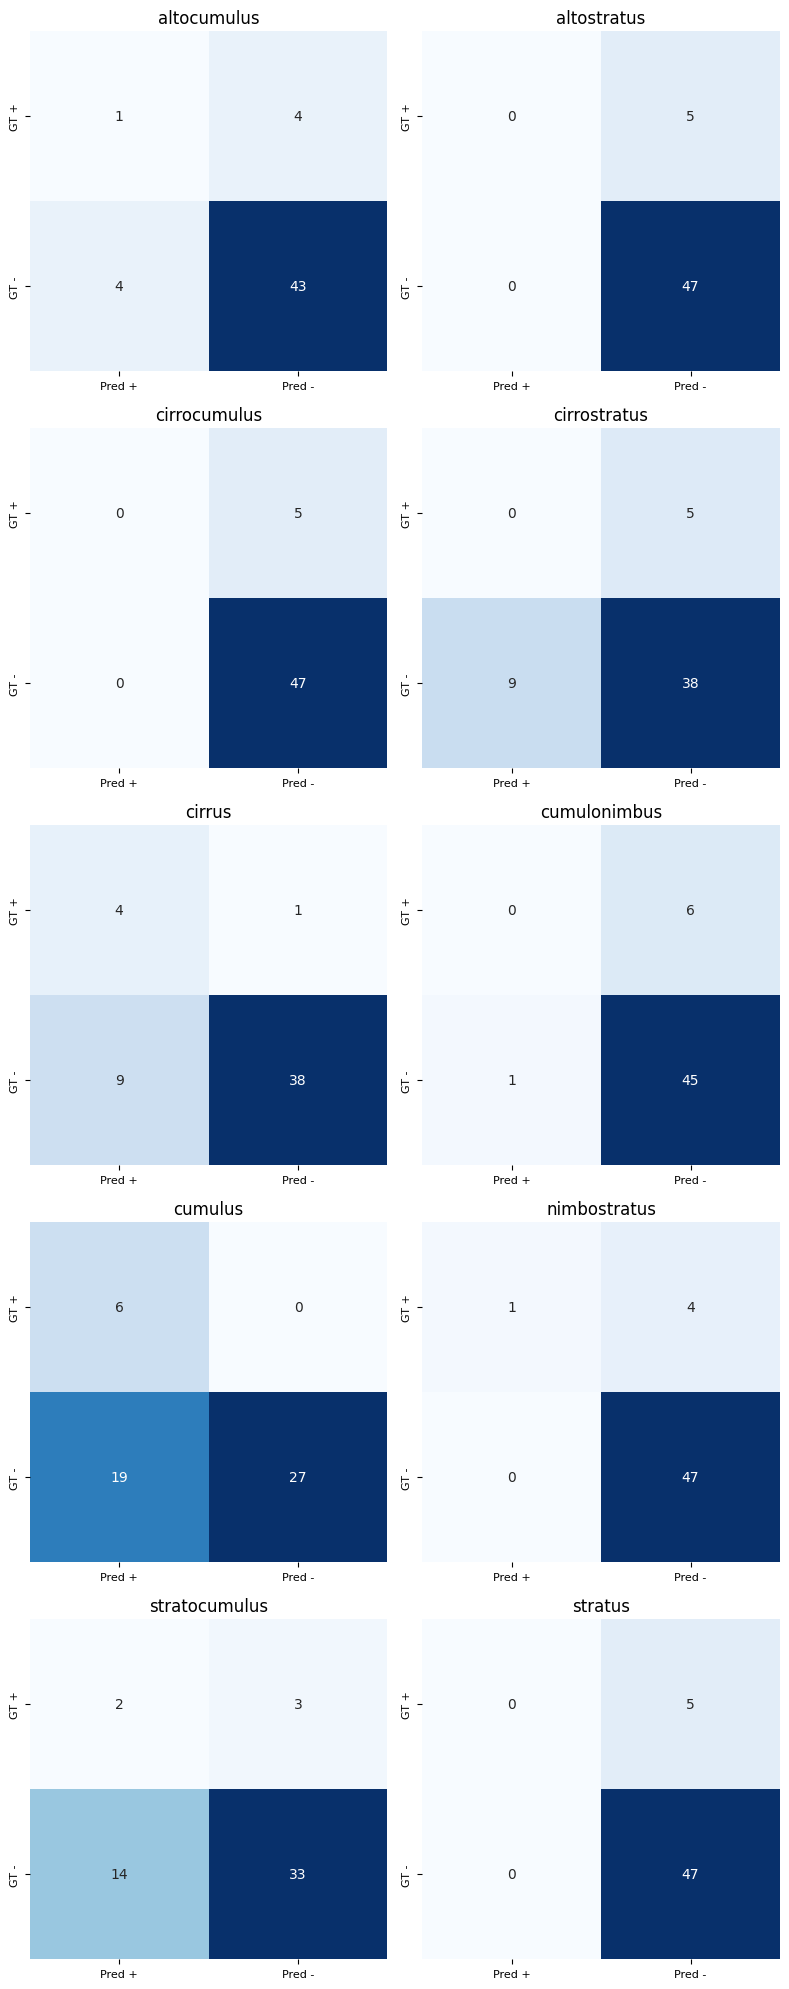

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrices(y_true, y_prob, thresholds, cols=CLOUD_COLS):
    stats = per_label_confusion(y_true, y_prob, thresholds)

    fig, axes = plt.subplots(5, 2, figsize=(8, 20))
    axes = axes.ravel()

    for i, s in enumerate(stats):
        cm = np.array([[s["TP"], s["FN"]],
                       [s["FP"], s["TN"]]])
        cm_pct = cm / cm.sum() if cm.sum() > 0 else cm

        sns.heatmap(
            cm_pct,
            annot=cm,
            fmt="d",
            cmap="Blues",
            cbar=False,
            xticklabels=["Pred +", "Pred -"],
            yticklabels=["GT +", "GT -"],
            ax=axes[i]
        )
        axes[i].set_title(s["label"])
        axes[i].tick_params(axis="both", labelsize=8)

    plt.tight_layout()
    plt.show()

thr_used = metrics_cas["thresholds_used"]
plot_confusion_matrices(y_true_cas, y_prob_cas, thr_used)
